# Interactias Geo Selected Network

One way of examining the impact of invasive species is to look at all their interactions and the interations those organisms have with each other. This full interaction network gives you an indication of whether a species might be a "keystone" species and therefore have a disproportionatly large impact.

In this step of the evolution of this script it will be adapted to quantify species by their occupancy.

I will harvest species interactions data from GloBI (https://www.globalbioticinteractions.org/) to discover the species that interact with an invasive species.
I will then harvest all the interactions for those species to create two tiers of interactions.
I will then count all the occurences of these in species in the Belgian datacube.
I will then visualize this.

This notebook takes considerable insperation and code from Yikang Li's project on GloBI (https://curiositydata.org/part1_globi_access/).


### For information: Invasive alien species of Union concern
|A|H|O|
|--|--|--|
|Acacia saligna|Herpestes javanicus|Pacifastacus leniusculus|
|Acridotheres tristis|Humulus scandens|Parthenium hysterophorus|
|Ailanthus altissima|Hydrocotyle ranunculoides|Pennisetum setaceum|
|Alopochen aegyptiaca|Impatiens glandulifera|Perccottus glenii|
|Alternanthera philoxeroides|Lagarosiphon major|Persicaria perfoliata|
|Andropogon virginicus|Lepomis gibbosus|Plotosus lineatus|
|Arthurdendyus triangulatus|Lespedeza cuneata|Procambarus clarkii|
|Asclepias syriaca|Lithobates catesbeianus|Procambarus fallax|
|Baccharis halimifolia|Ludwigia peploides|Procyon lotor|
|Cabomba caroliniana|Lygodium japonicum|Prosopis juliflora|
|Callosciurus erythraeus|Lysichiton americanus|Pseudorasbora parva|
|Cardiospermum grandiflorum|Microstegium vimineum|Pueraria montana|
|Cortaderia jubata|Muntiacus reevesi|Salvinia molesta|
|Corvus splendens|Myocastor coypus|Sciurus carolinensis|
|Ehrharta calycina|Myriophyllum aquaticum|Sciurus niger|
|Eichhornia crassipes|Myriophyllum heterophyllum|Tamias sibiricus|
|Elodea nuttallii|Nasua nasua|Threskiornis aethiopicus|
|Eriocheir sinensis|Nyctereutes procyonoides|Trachemys scripta|
|Gunnera tinctoria|Ondatra zibethicus|Triadica sebifera|
|Gymnocoronis spilanthoides|Orconectes limosus|Vespa velutina|
|Heracleum mantegazzianum|Orconectes virilis||
|Heracleum persicum|Oxyura jamaicensis||

In [3050]:
import sys
print(sys.version)

#Python 3.7.4 (default, Aug 9 2019, 18:34:13) [MSC v.1915 64 bit (AMD64)]
#pygbif 0.3.0

3.7.3 (default, Mar 27 2019, 17:13:21) [MSC v.1915 64 bit (AMD64)]


In [3051]:
import pandas as pd
import re
import matplotlib.pyplot as plt
from pygbif import species
from pygbif import occurrences as occ
import sqlite3
from sqlite3 import Error
import pydot
import math

### Setting up some parameters

In [3052]:
# There is no point accepting all the species that have more than one record.
# There are too many casual records of plants and birds
thresholdForOccNum = 5
# If you want to exclude an interaction add it here
#interactionsToExclude = "visitsFlowersOf" #If you're not intersted in pollinators this will remove most of them
interactionsToExclude = "interactsWith"    #Many interactions in GloBI do not specify a specific interaction. You can get a cleaner netwot by excluding them
interactionsToExclude = ""

In [3053]:

## Define the country of interest
country  = 'Belgium'

## The occurrence cube has data for each year, but here we aggreagate years to get a more complete measure of occupancy.
## This parameter defines the year from where to consider records for the occupancy
year = 2000

## Define the place to find the data cube for occupancy data
## Currently the cube contains only Belgian data so that is all that can be used#
# A script to create cube.db is here https://github.com/AgentschapPlantentuinMeise/occcube
database = r"..\..\data\cube.db" 

## A script to create globi.db is here https://github.com/AgentschapPlantentuinMeise/createGlobiDB
## Define the place to find the interaction data
globiDB = r"..\..\createGlobiDB\globi.db"

### Define the taxon for the notebook for which to find all interactions


In [3054]:
taxon=input()

Threskiornis aethiopicus


In [3055]:
taxon = taxon.strip()

## Check to see if the taxon exits in GBIF

In [3056]:
try:
    #NOTE: The function method name_suggest has a different behavior with regards to the gender of Latin names to name_backbone
    # If name_backbone is given a name in one gender it can still return the best match from the GBIF backbone if that
    # name is spelled as if it was another gender.
    #key = species.name_suggest(q=taxon, limit = 1)
    match = species.name_backbone(name=taxon, limit = 1)
    #print(key)
    
    # if there is no match this is returned form .name_backbone {'confidence': 100, 'matchType': 'NONE', 'synonym': False}
    if match['matchType'] == 'NONE':
        raise ValueError("TAXON NOT FOUND ON GBIF!")
    else:
        key = match['usageKey']
except ValueError as ve:
    print(ve)
    exit(1)




In [3057]:
fullScientificName = match['scientificName']
print('The taxon to be studied is ' + fullScientificName)


The taxon to be studied is Threskiornis aethiopicus (Latham, 1790)


### Just for information take a look at the interactions that the taxon has

In [3058]:
# What are all the types of interactions involving taxon as source taxon?
#data[data['sourceTaxonName'] == taxon]['interactionTypeName'].unique()
try:
    connGlobi = sqlite3.connect(globiDB)
except Error as e:
    print(e)

In [3059]:
curGlobi = connGlobi.cursor()
curGlobi.execute("SELECT interactionTypeName, COUNT(interactionTypeName) from globi  WHERE sourceTaxonSpeciesName = ? GROUP BY interactionTypeName;", (taxon,))
sourceInteractions = curGlobi.fetchall()

In [3060]:
sourceInteractions

[('eats', 53), ('interactsWith', 1)]

In [3061]:
curGlobi = connGlobi.cursor()
curGlobi.execute("SELECT interactionTypeName, COUNT(interactionTypeName) from globi  WHERE targetTaxonSpeciesName = ? GROUP BY interactionTypeName;", (taxon,))
targetInteractions = curGlobi.fetchall()
targetInteractions

[('ectoparasiteOf', 12),
 ('hasHost', 14),
 ('interactsWith', 9),
 ('parasiteOf', 2)]

## Get the primary interation data for the species in question

This is limited to the rank of species because otherwise the network can get very large with rather irrelivent higher taxa.
However, if no interactions are found at the species level it might be worth removing this restriction.

In [3062]:
curGlobi = connGlobi.cursor()
#curGlobi.execute("SELECT * from globi  WHERE targetTaxonName = ? and interactionTypeName NOT IN (?);", \
if interactionsToExclude == "":
    curGlobi.execute("SELECT * from globi  WHERE targetTaxonSpeciesName = ?;", \
                 (taxon,))
else:
    curGlobi.execute("SELECT * from globi  WHERE targetTaxonSpeciesName = ? and interactionTypeName NOT IN (?);", \
                 (taxon,interactionsToExclude,))
interactDataTaxon = curGlobi.fetchall()

In [3063]:
curGlobi = connGlobi.cursor()
#curGlobi.execute("SELECT * from globi  WHERE sourceTaxonName = ? and interactionTypeName NOT IN (?);", \
if interactionsToExclude == "":
    curGlobi.execute("SELECT * from globi  WHERE sourceTaxonSpeciesName = ?;", \
                 (taxon,))
else:
    curGlobi.execute("SELECT * from globi  WHERE sourceTaxonSpeciesName = ? and interactionTypeName NOT IN (?);", \
                 (taxon,interactionsToExclude,))
sources = curGlobi.fetchall()

In [3064]:
interactDataTaxon.extend(sources)
len(interactDataTaxon)

91

In [3065]:
# Convert to a Pandas dataframe
interactDataTaxon = pd.DataFrame(interactDataTaxon)

In [3066]:
# Add column names
interactDataTaxon
interactDataTaxon.columns = ['sourceTaxonId', \
                                'sourceTaxonIds','sourceTaxonName','sourceTaxonRank','sourceTaxonPathNames', \
                                'sourceTaxonPathIds','sourceTaxonPathRankNames','sourceTaxonSpeciesName','sourceTaxonSpeciesId',\
                                'sourceTaxonGenusName','sourceTaxonGenusId','sourceTaxonFamilyName','sourceTaxonFamilyId',\
                                'sourceTaxonOrderName','sourceTaxonOrderId','sourceTaxonClassName','sourceTaxonClassId',\
                                'sourceTaxonPhylumName','sourceTaxonPhylumId','sourceTaxonKingdomName','sourceTaxonKingdomId',\
                                'sourceId','sourceOccurrenceId','sourceCatalogNumber','sourceBasisOfRecordId',\
                                'sourceBasisOfRecordName','sourceLifeStageId','sourceLifeStageName','sourceBodyPartId',\
                                'sourceBodyPartName','sourcePhysiologicalStateId','sourcePhysiologicalStateName', \
                                'sourceSexId', 'sourceSexName','interactionTypeName',\
                                'interactionTypeId','targetTaxonId','targetTaxonIds','targetTaxonName',\
                                'targetTaxonRank','targetTaxonPathNames','targetTaxonPathIds','targetTaxonPathRankNames',\
                                'targetTaxonSpeciesName','targetTaxonSpeciesId','targetTaxonGenusName','targetTaxonGenusId',\
                                'targetTaxonFamilyName','targetTaxonFamilyId','targetTaxonOrderName','targetTaxonOrderId',\
                                'targetTaxonClassName','targetTaxonClassId','targetTaxonPhylumName','targetTaxonPhylumId',\
                                'targetTaxonKingdomName','targetTaxonKingdomId','targetId','targetOccurrenceId',\
                                'targetCatalogNumber','targetBasisOfRecordId','targetBasisOfRecordName','targetLifeStageId',\
                                'targetLifeStageName','targetBodyPartId','targetBodyPartName','targetPhysiologicalStateId',\
                                'targetPhysiologicalStateName', 'targetSexId', 'targetSexName',\
                                'decimalLatitude','decimalLongitude','localityId',\
                                'localityName','eventDateUnixEpoch','argumentTypeId','referenceCitation',\
                                'referenceDoi','referenceUrl','sourceCitation','sourceNamespace',\
                                'sourceArchiveURI','sourceDOI','sourceLastSeenAtUnixEpoch']

## Get a list of all the primary interacting species

In [3067]:
interactingTaxaData = interactDataTaxon.drop_duplicates()

In [3068]:
primaryInteractingTaxa = interactingTaxaData['sourceTaxonName'].drop_duplicates()
len(primaryInteractingTaxa)

16

In [3069]:
primaryInteractingTaxa = (primaryInteractingTaxa.append(interactingTaxaData['targetTaxonName']).drop_duplicates())
len(primaryInteractingTaxa)

64

In [3070]:
primaryInteractingTaxa

0                            Bubulcus ibis
1                      Spheniscus demersus
6               Plegadiphilus threskiornis
7                    Colpocephalum tandani
9                       Ardeicola freemani
10                       Ibidoecus tandani
11                 Colpocephalum pygidiale
12                        Ardeicola clayae
13                  Ibidoecus threskiornis
16                    Ardeicola intermedia
17                     Ibidoecus insularis
18                                   Acari
27                                 Cestoda
28                               Patagifer
36                 Newcastle disease virus
37                Threskiornis aethiopicus
11    Threskiornis aethiopicus aethiopicus
37                                 Sorghum
38               Citrullus lanatus lanatus
39                            Cucumis melo
40                           Carica papaya
41                        Arachis hypogaea
42                                Zea mays
43         

## A function to query the globi database

In [3071]:
def secondaryDataInGlobi(conn, intaxon):
    cur = conn.cursor()
    if interactionsToExclude == "":
        cur.execute("SELECT * from globi  WHERE (targetTaxonSpeciesName = ? OR sourceTaxonSpeciesName = ?);", \
                 (intaxon,intaxon,))
    else:
        cur.execute("SELECT * from globi where (targetTaxonSpeciesName = ? OR sourceTaxonSpeciesName = ?) and interactionTypeName NOT IN (?);", \
                (intaxon,intaxon,interactionsToExclude,))
    return(cur.fetchall())

## Get all the secondary interactions

In [3072]:
try:
    conn = sqlite3.connect(globiDB)
except Error as e:
    print(e)

In [3073]:
secondarylist = []

for name in primaryInteractingTaxa:
    temp = secondaryDataInGlobi(conn, name)
    secondarylist.extend(temp)

In [3074]:
# Convert to a Pandas dataframe
secondarylist = pd.DataFrame(secondarylist)

In [3075]:
secondarylist.columns = ['sourceTaxonId', \
                                'sourceTaxonIds','sourceTaxonName','sourceTaxonRank','sourceTaxonPathNames', \
                                'sourceTaxonPathIds','sourceTaxonPathRankNames','sourceTaxonSpeciesName','sourceTaxonSpeciesId',\
                                'sourceTaxonGenusName','sourceTaxonGenusId','sourceTaxonFamilyName','sourceTaxonFamilyId',\
                                'sourceTaxonOrderName','sourceTaxonOrderId','sourceTaxonClassName','sourceTaxonClassId',\
                                'sourceTaxonPhylumName','sourceTaxonPhylumId','sourceTaxonKingdomName','sourceTaxonKingdomId',\
                                'sourceId','sourceOccurrenceId','sourceCatalogNumber','sourceBasisOfRecordId',\
                                'sourceBasisOfRecordName','sourceLifeStageId','sourceLifeStageName','sourceBodyPartId',\
                                'sourceBodyPartName','sourcePhysiologicalStateId','sourcePhysiologicalStateName',\
                                'sourceSexId', 'sourceSexName', 'interactionTypeName',\
                                'interactionTypeId','targetTaxonId','targetTaxonIds','targetTaxonName',\
                                'targetTaxonRank','targetTaxonPathNames','targetTaxonPathIds','targetTaxonPathRankNames',\
                                'targetTaxonSpeciesName','targetTaxonSpeciesId','targetTaxonGenusName','targetTaxonGenusId',\
                                'targetTaxonFamilyName','targetTaxonFamilyId','targetTaxonOrderName','targetTaxonOrderId',\
                                'targetTaxonClassName','targetTaxonClassId','targetTaxonPhylumName','targetTaxonPhylumId',\
                                'targetTaxonKingdomName','targetTaxonKingdomId','targetId','targetOccurrenceId',\
                                'targetCatalogNumber','targetBasisOfRecordId','targetBasisOfRecordName','targetLifeStageId',\
                                'targetLifeStageName','targetBodyPartId','targetBodyPartName','targetPhysiologicalStateId',\
                                'targetPhysiologicalStateName', 'targetSexId', 'targetSexName', \
                                'decimalLatitude','decimalLongitude','localityId',\
                                'localityName','eventDateUnixEpoch','argumentTypeId','referenceCitation',\
                                'referenceDoi','referenceUrl','sourceCitation','sourceNamespace',\
                                'sourceArchiveURI','sourceDOI','sourceLastSeenAtUnixEpoch']

In [3076]:
allInteractionsData = interactingTaxaData.append(secondarylist)

In [3077]:
allInteractionsData = allInteractionsData.drop_duplicates()


In [3078]:
    cleanInteractDataTaxon = allInteractionsData[['sourceTaxonId', 'sourceTaxonName', 'sourceTaxonSpeciesName', 'sourceTaxonRank',
        'sourceTaxonFamilyName', 'interactionTypeName',
        'targetTaxonName','targetTaxonSpeciesName','targetTaxonRank', 'sourceCitation', 'sourceDOI',
        'sourceTaxonKingdomName','sourceTaxonKingdomId', 'targetTaxonKingdomName','targetTaxonKingdomId'                                        
        ]].dropna(subset=['targetTaxonSpeciesName','sourceTaxonSpeciesName'])

In [3079]:
allSourceInteractingTaxa = cleanInteractDataTaxon['sourceTaxonSpeciesName'].drop_duplicates()
allTargetInteractingTaxa = cleanInteractDataTaxon['targetTaxonSpeciesName'].drop_duplicates()

In [3080]:
allInteractingTaxa = allSourceInteractingTaxa.append(allTargetInteractingTaxa).drop_duplicates()
allInteractingTaxa.count()

3510

In [3081]:
allInteractingTaxa.head()

0                 Bubulcus ibis
1           Spheniscus demersus
6    Plegadiphilus threskiornis
7         Colpocephalum tandani
9            Ardeicola freemani
dtype: object

In [3082]:
# How many different sort of interaction do I have left?
# Checking out all the interaction types
cleanInteractDataTaxon.groupby(cleanInteractDataTaxon['interactionTypeName']).size().sort_values(ascending = False)

interactionTypeName
hasHost                  22230
eats                      7258
interactsWith             5123
parasiteOf                3115
pathogenOf                2770
preysOn                    443
endoparasiteOf             273
ectoparasiteOf             154
symbiontOf                 106
hasVector                   69
visitsFlowersOf             39
pollinates                  22
livesUnder                  14
adjacentTo                  11
coOccursWith                10
livesInsideOf                8
visits                       6
ecologicallyRelatedTo        5
kills                        2
hasDispersalVector           1
dtype: int64

### This function takes a name string and checks on GBIF to see if the name exists there.

In [3083]:
def speciesExistsInGBIF(name, rank):
    try:
        match = species.name_backbone(name=name, rank=rank, limit = 1)

        # if there is no match this is returned from .name_backbone {'confidence': 100, 'matchType': 'NONE', 'synonym': False}
        if match['matchType'] == 'NONE':
            return False
        else:
            return match
    except ValueError as ve:
        print(ve)
        exit(1)

### Check that the species in question is actually found on GBIF

In [3084]:
if(speciesExistsInGBIF(taxon, "species") == False):
    print("##### {0} has not been found on GBIF #####".format(taxon))

### Citation for the GBIF Backbone Taxonomy

In [3085]:
from datetime import date
print("GBIF Secretariat (2019). GBIF Backbone Taxonomy. Checklist dataset https://doi.org/10.15468/39omei accessed via GBIF.org on ", date.today())

GBIF Secretariat (2019). GBIF Backbone Taxonomy. Checklist dataset https://doi.org/10.15468/39omei accessed via GBIF.org on  2020-07-24


### Check to see which taxa in the interaction network are found in GBIF and list those ones that are not

In [3086]:
taxaFound = {}
kingdom = {}

print('Taxa from GLoBI, but not found in GBIF')
for name in allInteractingTaxa.items():
    GBIFName = speciesExistsInGBIF(name[1], "species")
    if GBIFName == False:
        taxaFound[name[1]] = False
        print(name[1])
    else:
        taxaFound[name[1]] = GBIFName['usageKey']
        kingdom[name[1]] = GBIFName['kingdom']

    

Taxa from GLoBI, but not found in GBIF

Newcastle disease virus
Ascaroidea
Wild melon vein banding virus
Sudan watermelon mosaic virus
Melon partitivirus
Cucurbit chlorotic yellows virus
Watermelon silver mottle virus
Nectria
Sphaerotheca
Papaya meleira virus
Papaya leaf curl Faisalabad virus
Papaya leaf curl alphasatellite
Spilarctia obliqua
Groundnut bud necrosis virus
Groundnut yellow spot virus
Groundnut ringspot virus
Zea mays/Colletotrichum graminicola mixed EST library
Maize mosaic virus
Maize fine streak virus
Wheat mosaic virus
undetermined Cottoidei Lake Baikal
Mexican
Candidatus Phytoplasma solani
Maize bushy stunt phytoplasma
Zea mays chrysovirus 1
Maize-associated totivirus 3
Maize-associated totivirus 2
Maize-associated totivirus 1
Maize striate mosaic virus
Maize stripe virus
Rotavirus
Visna/Maedi virus
Ovine herpesvirus 2
Ovine astrovirus
Ovine adenovirus
Border disease virus
Alcelaphine herpesvirus 1
Rinderpest virus
Peste-des-petits-ruminants virus
Bovine viral diarrh

In [3087]:
# Convert to a Pandas dataframe
taxaFound = pd.DataFrame.from_dict(taxaFound, orient='index')

In [3088]:
len(taxaFound)

3510

In [3089]:
kingdom

{'Bubulcus ibis': 'Animalia',
 'Spheniscus demersus': 'Animalia',
 'Plegadiphilus threskiornis': 'Animalia',
 'Colpocephalum tandani': 'Animalia',
 'Ardeicola freemani': 'Animalia',
 'Ibidoecus tandani': 'Animalia',
 'Colpocephalum pygidiale': 'Animalia',
 'Ardeicola clayae': 'Animalia',
 'Ibidoecus threskiornis': 'Animalia',
 'Ardeicola intermedia': 'Animalia',
 'Ibidoecus insularis': 'Animalia',
 'Threskiornis aethiopicus': 'Animalia',
 'Phrynobatrachus mababiensis': 'Animalia',
 'Haliaeetus leucocephalus': 'Animalia',
 'Desportesius invaginatus': 'Animalia',
 'Culex tarsalis': 'Animalia',
 'Aedes taeniorhynchus': 'Animalia',
 'Threskiornis melanocephalus': 'Animalia',
 'Ardea alba': 'Animalia',
 'Ardeicola expallidus': 'Animalia',
 'Ardeicola gaibagla': 'Animalia',
 'Comatomenopon ibis': 'Animalia',
 'Avian coronavirus': 'Viruses',
 'Eunectes notaeus': 'Animalia',
 'Ciconiphilus decimfasciatus': 'Animalia',
 'Clinostomum giganticum': 'Animalia',
 'Oxyspirura petrowi': 'Animalia',
 '

### This function takes a GBIF species key and counts how many occurences exist in the data cube

In [3090]:
def speciesCountInCube(conn, key):
    cur = conn.cursor()
    cur.execute("SELECT COUNT(taxonKey) from (SELECT taxonKey FROM cube WHERE year > ? and taxonKey = ? GROUP BY eea_cell_code)", (year, key,))
    return(cur.fetchall())

### Loop over all the taxa that are in the interaction network and are in GBIF to find the ones that have been found in the country

In [3091]:
taxaFoundInCountry = []

try:
    conn = sqlite3.connect(database)
except Error as e:
    print(e)

In [3092]:
year

2000

In [3093]:
for GBIFtaxon in taxaFound.iterrows():
    GBIFOccCount = speciesCountInCube(conn, GBIFtaxon[1][0])
    print(GBIFtaxon[0])
    if GBIFOccCount[0][0] > thresholdForOccNum and GBIFtaxon[0] != taxon: # The threshold for observations is not greater than one, due to all the casual records
        taxaFoundInCountry.append({'key': GBIFtaxon[1][0], 'species': GBIFtaxon[0], 'count': GBIFOccCount[0][0]})
        print('{0} with key {1} occurs in {2} km squares.'.format(GBIFtaxon[0],GBIFtaxon[1][0],GBIFOccCount[0][0]))
    elif GBIFtaxon[0] == taxon:
        taxaFoundInCountry.append({'key': GBIFtaxon[1][0], 'species': GBIFtaxon[0], 'count': GBIFOccCount[0][0]})
        print('{0} with key {1} occurs in {2} km squares.'.format(GBIFtaxon[0],GBIFtaxon[1][0],GBIFOccCount[0][0]))

Bubulcus ibis
Bubulcus ibis with key 2480830 occurs in 1383 km squares.
Spheniscus demersus
Plegadiphilus threskiornis
Colpocephalum tandani
Ardeicola freemani
Ibidoecus tandani
Colpocephalum pygidiale
Ardeicola clayae
Ibidoecus threskiornis
Ardeicola intermedia
Ibidoecus insularis

Newcastle disease virus
Threskiornis aethiopicus
Threskiornis aethiopicus with key 2480764 occurs in 272 km squares.
Phrynobatrachus mababiensis
Haliaeetus leucocephalus
Haliaeetus leucocephalus with key 2480446 occurs in 13 km squares.
Desportesius invaginatus
Culex tarsalis
Aedes taeniorhynchus
Threskiornis melanocephalus
Ardea alba
Ardea alba with key 9752617 occurs in 11374 km squares.
Ardeicola expallidus
Ardeicola gaibagla
Comatomenopon ibis
Avian coronavirus
Eunectes notaeus
Ciconiphilus decimfasciatus
Clinostomum giganticum
Oxyspirura petrowi
Tinaminyssus bubulci
Nyamanini nyavirus
Nephrostomum bicolanum
Microtetrameres corax
Uroproctepisthmium taiwanense
Desportesius spinulatus
Microtetrameres spir

Neoasaia chiangmaiensis
Paenibacillus cineris
Bacillus fusiformis
Pseudomonas putida
Carica papaya
Chaetomium cochliodes
Emericella rugulosa
Fusarium chlamydosporum
Melanospora zamiae
Eupenicillium
Carduelis chloris
Aspergillus flavus
Botrytis cinerea
Tomato spotted wilt orthotospovirus
Peanut stunt virus
Bean common mosaic virus
Peanut mottle virus
Aphelenchoides arachidis
Belonolaimus longicaudatus
Scutellonema cavenessi
Ditylenchus destructor
Pratylenchus coffeae
Pratylenchus brachyurus
Macroposthonia ornata
Mesocriconema ornatum
Bitylenchus brevilineatus
Xiphinema americanum
Grovesinia pyramidalis
Nakataea oryzae
Cristulariella
Didymosphaeria arachidicola
Ascochyta
Verticillium albo-atrum
Sclerotinia sclerotiorum
Sclerotinia minor
Elsinoë veneta
Pythium irregulare
Phanerochaete omnivora
Phymatotrichopsis omnivora
Pleosphaerulina
Diaporthe phaseolorum
Pestalotiopsis palmarum
Leptosphaerulina
Olpidium brassicae
Myrothecium roridum
Pleospora tarda
Mycosphaerella berkeleyi
Passalora ba

Myzocallis punctatus
Geoica squamosa
Nearctaphis crataegifoliae
Rhopalosiphum insertum
Uroleucon gravicorne
Uroleucon nigrotuberculatum
Protaphis middletonii
Colopha ulmicola
Helicoverpa zea
Luscinia svecica
Luscinia svecica with key 4408732 occurs in 7229 km squares.
Didelphis virginiana
Psittacara leucophthalmus
Acharia stimulea
Hippodamia convergens
Homalodisca insolita
Cyanocorax chrysops
Cyanocorax cristatellus
Columbina squammata
Sicalis flaveola
Tamias striatus
Vespula germanica
Vespula germanica with key 1311649 occurs in 955 km squares.
Columbina talpacoti
Molothrus bonariensis
Chrysomus ruficapillus
Tetranychus urticae
Calopteron reticulatum
Cotinis nitida
Melissodes bimaculatus
Diabrotica undecimpunctata
Prosapia bicincta
Spodoptera ornithogalli
Arilus cristatus
Cycloneda sanguinea
Blastopsylla occidentalis
Vulpes vulpes
Vulpes vulpes with key 5219243 occurs in 43 km squares.
Pieris rapae
Pieris rapae with key 1920496 occurs in 14956 km squares.
Trichogramma brassicae
Tricho

Coprinopsis utrifer
Sigorus porcus
Pseudombrophila theioleuca
Mycocalia denudata
Podospora intestinacea
Cercophora coprophila
Stropharia semiglobata
Ascodesmis nigricans
Cercophora mirabilis
Pyronema omphalodes
Onygena corvina
Onygena equina
Leptosphaerulina chartarum
Planolinoides borealis
Esymus pusillus
Podospora pauciseta
Coprotus granuliformis
Chaetomium globosum
Sphaerodes fimicola
Delitschia canina
Trypocopris vernalis
Toxocara cati
Toxocara canis
Echinococcus granulosus
Saccobolus depauperatus
Saccobolus citrinus
Ascobolus stictoideus
Ascobolus albidus
Panaeolus subfirmus
Delitschia patagonica
Odonteus armiger
Podospora myriospora
Sporormiella grandispora
Ascobolus equinus
Pyxidiophora microspora
Coprinopsis filamentifer
Onthophagus joannae
Lucilia sericata
Ixodes ricinus
Antilocapra americana
Monodictys asperospora
Agoliinus lapponum
Coprotus lacteus
Coprinopsis vermiculifer
Hypocopra merdaria
Cheilymenia raripila
Sporormiella pulchella
Sporormiella australis
Schizothecium his

Otobius megnini
Nematodirus oriatianus interuptus
Nematodirus furcataus
Moniezia denticulata
Rhipicephalus annulatus
Linognathus arfricanus
Ixodes affinis
Globodium
Eimeria intricata
Dermacentor andersoni
Dermacentor variabilis
Demodex folliculorum
Cotylophoron indicum
Chorioptes bovis
Rhipicephalus microplus
Amblyomma maculatum
Adenomata
Eremoplastron neglectum
Eremoplastron dilobum
Eremoplastron rostratum
Ophryoscolex caudatus
Phoma
Entodinium nanellum
Entodinium bursa
Entodinium dubardi
Entodinium furca
Entodinium caudatum
Polyplastron multivesiculatum
Dasytricha ruminantium
Eudiplodinium maggii
Eubacterium cellulosolvens
Mannheimia ruminalis
Enoploplastron triloricatum
Howardella ureilytica
Eimeria ovinoidalis
Eimeria crandallis
Moraxella ovis
Eimeria ahsata
Eubacterium albensis
Candida albicans
Mannheimia haemolytica
Clostridium novyi
Brucella ovis
Giardia lamblia
Corynebacterium pseudotuberculosis
Campylobacter fetus
Streptococcus pneumoniae
Chlamydophila psittaci
Trypanosoma con

Sarcocystis rileyi
Notocotylus attenuatus
Hypoderaeum conoideum
Cyathocotyle orientalis
Taenia conica
Echinoparyphium recurvatum
Echinostoma sp.
Raillietina paucitesticulata
Tracheophilus cymbium
Polymorphus acutis
Philophthalmus gralli
Echinoparyphium sp.
Capillaria contorta
Ribeiroia thomasi
Tetrameres ryjikovi
Sphaeridiotrema globulus
Cyathocotyle szidatiana
Amidostomum sp.
Fimbriaria sp.
Epomidiostomum crami
Amphimerus anatis
Diorchis sp.
Aploparaksis furcifera
Typhlocoelum sisowi
Apatemon gracilis
Sphaeridiotrema pseudoglobulus
Eucotyle warreni
Weinlandia sp.
Plasmodium forresteri
Eucotyle wehri
Tetrameres americana
Apatemon jamesi
Hystrichis varispinosus
Polymorphus boschadis
Balbiania rileyi
Prosthogonimus cuneatus
Diplostomum baeri
Linstowiella orientalis
Gastrotaenia cygni
Typhlocoelum cucumerinum
Prosthorhynchus sp.
Fimbriarioides sp.
Hystrichis sp.
Tyzzeria perniciosa
Tropisurus sp.
Manterocoelum americanum
Dicranotaenia introversa
Streptocara incognita
Aploparaksis veitchi


Tringa nebularia
Tringa nebularia with key 2481726 occurs in 6049 km squares.
Anguillid perhabdovirus
Potamipivirus A
Anguillid herpesvirus 1
Anguilla anguilla circovirus
Neoechinorhynchus rutili
Pomphorhynchus sp.
Gyrodactylus anguillae
Bucephalus anguillae
Gyrodactylus friendi
Echinorhynchus sp.
Lecithochirium gravidum
Nicolla gallica
Molva molva
Gavia immer
Gavia immer with key 2481962 occurs in 671 km squares.
Phalacrocorax auritus
NEOECHINORHYNCHUS (N.) RUTILI
Flavobacterium psychrophilum
Infectious pancreatic necrosis virus
Pseudodactylogyrus bini
Aeromonas bestiarum
Viral hemorrhagic septicemia virus
Delftia acidovorans
Myxobolus portucalensis
Hoferellus gilsoni
Myxidium giardi
Eimeria anguillae
Pseudodactylogyrus anguillae
Edwardsiella tarda
Anguilla anguilla
Anguilla anguilla with key 5212973 occurs in 1834 km squares.
Dactylogyrus vistulae
Caryophyllaeides fennica
Caryophyllaeus laticeps
Argulus foliaceus
Ligula intestinalis
Tylodelphys clavata
Bucephala clangula
Bucephala cl

Nucella lapillus
Zoarces viviparus
Zoarces viviparus with key 2381013 occurs in 35 km squares.
Stramonita canaliculata
Calidris alpina
Calidris alpina with key 2481759 occurs in 3775 km squares.
Arenaria interpres
Arenaria interpres with key 2481776 occurs in 1201 km squares.
Haematopus ostralegus
Haematopus ostralegus with key 7788295 occurs in 10448 km squares.
Tadorna tadorna
Tadorna tadorna with key 2498009 occurs in 9169 km squares.
Pomatoschistus microps
Pomatoschistus microps with key 2379280 occurs in 146 km squares.
Ammodytes tobianus
Ammodytes tobianus with key 2389991 occurs in 341 km squares.
Pleuronectes platessa
Pleuronectes platessa with key 7700106 occurs in 530 km squares.
Melanitta nigra
Melanitta nigra with key 2498247 occurs in 956 km squares.
Histrionicus histrionicus
Anas rubripes
Corvus caurinus
Liparis callyodon
Rachycentron canadum
Enchelyopus cimbrius
Enchelyopus cimbrius with key 5214892 occurs in 6 km squares.
Limanda limanda
Limanda limanda with key 5213960

Turdus merula
Turdus merula with key 2490719 occurs in 15453 km squares.
Accipiter gularis
Asio otus
Asio otus with key 2497306 occurs in 6078 km squares.
Melopsittacus undulatus
Melopsittacus undulatus with key 2479798 occurs in 292 km squares.
Bonasa bonasia
Pavo cristatus
Pavo cristatus with key 9451184 occurs in 214 km squares.
Anas formosa
Anas formosa with key 2498107 occurs in 110 km squares.
Sternula albifrons
Sternula albifrons with key 5789279 occurs in 669 km squares.
Anas clypeata
Anas clypeata with key 2498089 occurs in 8390 km squares.
Anas penelope
Anas penelope with key 2498111 occurs in 6801 km squares.
Dendrocopos major
Dendrocopos major with key 2477968 occurs in 14212 km squares.
Rallus aquaticus
Rallus aquaticus with key 2474831 occurs in 6763 km squares.
Dromaius novaehollandiae
Aythya ferina
Aythya ferina with key 2498255 occurs in 7779 km squares.
Calidris alba
Calidris alba with key 2481748 occurs in 1474 km squares.
Calidris minutilla
Anser fabalis
Anser fabal

Rattus norvegicus
Rattus norvegicus with key 2439261 occurs in 3819 km squares.
Macrodon ancylodon
Pomatomus saltatrix
Nannobrachium achirus
Merluccius bilinearis
Notopogon fernandezianus
Odontesthes incisa
Electrona risso
Common
Peprilus burti
Pseudopentaceros wheeleri
Paralonchurus brasiliensis
Odontesthes argentinensis
Micropogonias furnieri
Anchoa marinii
Praunus flexuosus


In [3094]:
# Convert to a Pandas dataframe
taxaFoundInCountry = pd.DataFrame(taxaFoundInCountry)    

In [3095]:
print("The number of species left in the network is {0}".format(len(taxaFoundInCountry)))

The number of species left in the network is 332


In [3096]:
taxaFoundInCountry

,count,key,species
0,1383,2480830,Bubulcus ibis
1,272,2480764,Threskiornis aethiopicus
2,13,2480446,Haliaeetus leucocephalus
3,11374,9752617,Ardea alba
4,63,9083295,Aphis gossypii
5,63,9083295,Aphis (Aphis) gossypii
6,12828,4299368,Vanessa cardui
7,7,1047583,Acalymma vittatum
8,105,1353363,Halictus confusus
9,7053,1341976,Apis mellifera


## Drawing a network of the interactions

Now that I have a list of all the species in the country I can use this as my nodes list for the network diagram.

In [3097]:
#networkx seems to be a leading network tool in Python
import networkx as nx
import matplotlib.pyplot as plt

try:
    import pygraphviz
    from networkx.drawing.nx_agraph import write_dot
    print("using package pygraphviz")
except ImportError:
    try:
        import pydot
        from networkx.drawing.nx_pydot import write_dot
        print("using package pydot")
    except ImportError:
        print()
        print("Both pygraphviz and pydot were not found ")
        print("see  https://networkx.github.io/documentation/latest/reference/drawing.html")
        print()

using package pydot


In [3098]:
# Create graphic object
G = nx.DiGraph()

In [3099]:
# Match colours to interactions to distinguish them on the graph
colorInteractions = {'interaction':['pollinates', 'mutualistOf', 'eats', 'visitsFlowersOf', 'hasHost', 'parasiteOf', 'pathogenOf'],
        'colour':['r', 'g', 'b', 'y', 'm', 'w', 'c']}  

colorInteractionsDf = pd.DataFrame(colorInteractions)

#len(list(G.nodes))

## A quick look at the interaction data to see if it is what is expected

In [3100]:
#cleanInteractDataTaxon.loc[(cleanInteractDataTaxon["sourceTaxonName"] == 'Apis mellifera') & (cleanInteractDataTaxon["targetTaxonName"] == 'Procyon lotor')]
cleanInteractDataTaxon.loc[(cleanInteractDataTaxon["sourceTaxonSpeciesName"] == 'Bombus hortorum')]

,sourceTaxonId,sourceTaxonName,sourceTaxonSpeciesName,sourceTaxonRank,sourceTaxonFamilyName,interactionTypeName,targetTaxonName,targetTaxonSpeciesName,targetTaxonRank,sourceCitation,sourceDOI,sourceTaxonKingdomName,sourceTaxonKingdomId,targetTaxonKingdomName,targetTaxonKingdomId


## Figure out which node has the most records. This is so that the graphic can be scaled.

In [3101]:
if len(taxaFoundInCountry) > 0:
    maxRecords = taxaFoundInCountry.max()["count"]
    print(maxRecords)

17217


### Add the nodes to the graph

In [3102]:
dictOfNodeSizes = {}

for index, row in taxaFoundInCountry.iterrows():
     # access data using column names
    #print('A: ', row['species'], row['count'], row['key'])
    G.add_node(row['species'], gbifkey=row['key'], occupancy = row['count'])
    #create a list of node sizes scaled for the network visulization
    #The square root ensures that the node area is proportional to the occupancy, rather than the radius
    dictOfNodeSizes[row['species']] = math.sqrt(int(row['count']/maxRecords*100))*10

### Add edges to the graph

In [3103]:
# iterate over the interacting species that are in GBIF and in the country with iterrows()
# Find the taxa found in the country that are in the source taxon name of the interation data,
# then add the edge if the target species is in the country too.

taxaFoundInCountry_copy = taxaFoundInCountry.copy()

for index, row in taxaFoundInCountry.iterrows():
    # loop over all the taxa finding if any of them are mentioned in the sourceTaxonName field
    for edge in cleanInteractDataTaxon.iterrows():
        if row['species'] == edge[1]['sourceTaxonSpeciesName']:
            #print('B: ', edge[1]['sourceTaxonName'], edge[1]['targetTaxonName'])
            # Some of the target species will not be in GBIF of in the country, so only add an edge where they are.
            for index2, row2 in taxaFoundInCountry_copy.iterrows():
                #print('E: ', row2['species'], edge[1]['targetTaxonName'])
                if row2['species'] == edge[1]['targetTaxonSpeciesName']: 
                    print('C: ', edge[1]['targetTaxonSpeciesName'], row['species'], edge[1]['interactionTypeName'])
                    G.add_edge(row['species'], edge[1]['targetTaxonSpeciesName'], label = edge[1]['interactionTypeName'])
                    
#len(list(G.nodes))


C:  Threskiornis aethiopicus Bubulcus ibis interactsWith
C:  Threskiornis aethiopicus Bubulcus ibis interactsWith
C:  Threskiornis aethiopicus Bubulcus ibis interactsWith
C:  Gallinula chloropus Bubulcus ibis interactsWith
C:  Nycticorax nycticorax Bubulcus ibis interactsWith
C:  Gallinula chloropus Bubulcus ibis interactsWith
C:  Nycticorax nycticorax Bubulcus ibis interactsWith
C:  Hirundo rustica Bubulcus ibis preysOn
C:  Hirundo rustica Bubulcus ibis eats
C:  Ardea alba Bubulcus ibis interactsWith
C:  Athalia lugens Bubulcus ibis eats
C:  Eristalis tenax Bubulcus ibis eats
C:  Mantis religiosa Bubulcus ibis eats
C:  Mantis religiosa Bubulcus ibis eats
C:  Mus musculus Bubulcus ibis eats
C:  Mus musculus Bubulcus ibis eats
C:  Mantis religiosa Bubulcus ibis eats
C:  Forficula auricularia Bubulcus ibis eats
C:  Labidura riparia Bubulcus ibis eats
C:  Vespula germanica Bubulcus ibis eats
C:  Gryllotalpa gryllotalpa Bubulcus ibis eats
C:  Scymnus schmidti Bubulcus ibis eats
C:  Oryctes

C:  Larus argentatus Haliaeetus leucocephalus eats
C:  Larus argentatus Haliaeetus leucocephalus eats
C:  Larus argentatus Haliaeetus leucocephalus eats
C:  Larus argentatus Haliaeetus leucocephalus eats
C:  Larus argentatus Haliaeetus leucocephalus eats
C:  Larus argentatus Haliaeetus leucocephalus eats
C:  Larus argentatus Haliaeetus leucocephalus eats
C:  Larus argentatus Haliaeetus leucocephalus eats
C:  Larus argentatus Haliaeetus leucocephalus eats
C:  Larus argentatus Haliaeetus leucocephalus eats
C:  Larus argentatus Haliaeetus leucocephalus eats
C:  Larus argentatus Haliaeetus leucocephalus eats
C:  Larus argentatus Haliaeetus leucocephalus eats
C:  Larus argentatus Haliaeetus leucocephalus eats
C:  Larus argentatus Haliaeetus leucocephalus eats
C:  Larus argentatus Haliaeetus leucocephalus eats
C:  Larus argentatus Haliaeetus leucocephalus eats
C:  Larus argentatus Haliaeetus leucocephalus eats
C:  Larus argentatus Haliaeetus leucocephalus eats
C:  Larus argentatus Haliaeetus

C:  Cucumis melo Halictus confusus interactsWith
C:  Cucumis melo Halictus confusus interactsWith
C:  Cucumis melo Halictus confusus interactsWith
C:  Cucumis melo Halictus confusus interactsWith
C:  Cucumis melo Halictus confusus interactsWith
C:  Cucumis melo Halictus confusus interactsWith
C:  Cucumis melo Halictus confusus interactsWith
C:  Cucumis melo Halictus confusus interactsWith
C:  Cucumis melo Halictus confusus interactsWith
C:  Cucumis melo Halictus confusus interactsWith
C:  Cucumis melo Halictus confusus interactsWith
C:  Cucumis melo Halictus confusus interactsWith
C:  Cucumis melo Halictus confusus interactsWith
C:  Cucumis melo Halictus confusus interactsWith
C:  Cucumis melo Halictus confusus interactsWith
C:  Cucumis melo Halictus confusus interactsWith
C:  Cucumis melo Halictus confusus interactsWith
C:  Cucumis melo Halictus confusus interactsWith
C:  Cucumis melo Halictus confusus interactsWith
C:  Cucumis melo Halictus confusus interactsWith
C:  Cucumis melo Hal

C:  Zea mays Anser albifrons eats
C:  Zea mays Anser albifrons eats
C:  Zea mays Anser albifrons eats
C:  Zea mays Anser albifrons eats
C:  Zea mays Anser albifrons eats
C:  Zea mays Anser albifrons eats
C:  Zea mays Anser albifrons eats
C:  Zea mays Anser albifrons eats
C:  Zea mays Anser albifrons eats
C:  Zea mays Anser albifrons eats
C:  Zea mays Anser albifrons eats
C:  Zea mays Anser albifrons eats
C:  Zea mays Anser albifrons eats
C:  Zea mays Anser albifrons eats
C:  Zea mays Anas discors eats
C:  Zea mays Anas discors eats
C:  Zea mays Anas discors eats
C:  Zea mays Anas americana eats
C:  Zea mays Anas americana eats
C:  Zea mays Anas americana eats
C:  Zea mays Anas americana eats
C:  Zea mays Anas americana eats
C:  Zea mays Anas americana eats
C:  Zea mays Anas americana eats
C:  Zea mays Anas americana eats
C:  Zea mays Anas americana eats
C:  Zea mays Anas americana eats
C:  Zea mays Anas americana eats
C:  Zea mays Anas americana eats
C:  Zea mays Alopochen aegyptiaca e

C:  Zea mays Luscinia svecica interactsWith
C:  Zea mays Vespula germanica eats
C:  Zea mays Vulpes vulpes interactsWith
C:  Zea mays Pieris rapae interactsWith
C:  Zea mays Brachymeria tibialis parasiteOf
C:  Zea mays Brachymeria tibialis parasiteOf
C:  Zea mays Euplectrus bicolor parasiteOf
C:  Zea mays Lymantria dispar eats
C:  Zea mays Acronicta rumicis eats
C:  Zea mays Leptinotarsa decemlineata interactsWith
C:  Zea mays Labidura riparia interactsWith
C:  Zea mays Labidura riparia interactsWith
C:  Zea mays Labidura riparia interactsWith
C:  Zea mays Agrotis segetum eats
C:  Zea mays Agrotis segetum eats
C:  Zea mays Agrotis segetum eats
C:  Zea mays Agrotis segetum eats
C:  Zea mays Agrotis segetum eats
C:  Zea mays Agrotis segetum eats
C:  Zea mays Agrotis segetum eats
C:  Zea mays Agrotis segetum eats
C:  Zea mays Agrotis segetum eats
C:  Zea mays Agrotis segetum eats
C:  Zea mays Agrotis segetum eats
C:  Zea mays Agrotis segetum eats
C:  Zea mays Agrotis segetum eats
C:  Zea 

C:  Hediste diversicolor Vanellus vanellus interactsWith
C:  Fulica atra Dreissena polymorpha interactsWith
C:  Fulica atra Dreissena polymorpha interactsWith
C:  Fulica atra Dreissena polymorpha interactsWith
C:  Larus argentatus Dreissena polymorpha interactsWith
C:  Larus argentatus Dreissena polymorpha interactsWith
C:  Larus argentatus Dreissena polymorpha interactsWith
C:  Rutilus rutilus Dreissena polymorpha interactsWith
C:  Rutilus rutilus Dreissena polymorpha interactsWith
C:  Rutilus rutilus Dreissena polymorpha interactsWith
C:  Cyprinus carpio Dreissena polymorpha interactsWith
C:  Cyprinus carpio Dreissena polymorpha interactsWith
C:  Cyprinus carpio Dreissena polymorpha interactsWith
C:  Fulica atra Ardea cinerea eats
C:  Anas platyrhynchos Ardea cinerea interactsWith
C:  Anguilla anguilla Ardea cinerea interactsWith
C:  Anguilla anguilla Ardea cinerea interactsWith
C:  Anguilla anguilla Ardea cinerea eats
C:  Anguilla anguilla Ardea cinerea eats
C:  Anguilla anguilla Ar

C:  Hediste diversicolor Chroicocephalus ridibundus interactsWith
C:  Carassius auratus Chroicocephalus ridibundus preysOn
C:  Carassius auratus Chroicocephalus ridibundus preysOn
C:  Crangon crangon Chroicocephalus ridibundus interactsWith
C:  Platichthys flesus Chroicocephalus ridibundus interactsWith
C:  Clupea harengus Chroicocephalus ridibundus interactsWith
C:  Sprattus sprattus Chroicocephalus ridibundus interactsWith
C:  Hediste diversicolor Chroicocephalus ridibundus interactsWith
C:  Anas platyrhynchos Oncorhynchus mykiss interactsWith
C:  Cyprinus carpio Oncorhynchus mykiss preysOn
C:  Canis lupus Anas platyrhynchos interactsWith
C:  Corvus corax Anas platyrhynchos interactsWith
C:  Felis silvestris Anas platyrhynchos interactsWith
C:  Procyon lotor Anas platyrhynchos interactsWith
C:  Ceratophyllum demersum Anas platyrhynchos eats
C:  Stuckenia pectinata Anas platyrhynchos eats
C:  Beckmannia syzigachne Anas platyrhynchos eats
C:  Scolochloa festucacea Anas platyrhynchos ea

C:  Sterna hirundo Sprattus sprattus interactsWith
C:  Chroicocephalus ridibundus Platichthys flesus interactsWith
C:  Chroicocephalus ridibundus Platichthys flesus interactsWith
C:  Chroicocephalus ridibundus Platichthys flesus interactsWith
C:  Larus argentatus Platichthys flesus interactsWith
C:  Larus argentatus Platichthys flesus interactsWith
C:  Larus argentatus Platichthys flesus interactsWith
C:  Anguilla anguilla Platichthys flesus interactsWith
C:  Anguilla anguilla Platichthys flesus interactsWith
C:  Anguilla anguilla Platichthys flesus eats
C:  Anguilla anguilla Platichthys flesus eats
C:  Anguilla anguilla Platichthys flesus interactsWith
C:  Rutilus rutilus Platichthys flesus eats
C:  Mytilus edulis Platichthys flesus interactsWith
C:  Mytilus edulis Platichthys flesus interactsWith
C:  Mytilus edulis Platichthys flesus eats
C:  Mytilus edulis Platichthys flesus eats
C:  Mytilus edulis Platichthys flesus preysOn
C:  Mytilus edulis Platichthys flesus eats
C:  Mytilus edu

C:  Sterna hirundo Asio flammeus eats
C:  Sterna hirundo Asio flammeus eats
C:  Sterna hirundo Asio flammeus eats
C:  Sterna hirundo Asio flammeus eats
C:  Sterna hirundo Asio flammeus eats
C:  Sterna hirundo Asio flammeus eats
C:  Sterna hirundo Asio flammeus eats
C:  Sterna hirundo Asio flammeus eats
C:  Sterna hirundo Asio flammeus eats
C:  Sterna hirundo Asio flammeus eats
C:  Sterna hirundo Asio flammeus eats
C:  Sterna hirundo Asio flammeus eats
C:  Sterna hirundo Asio flammeus eats
C:  Sterna hirundo Asio flammeus eats
C:  Sterna hirundo Asio flammeus eats
C:  Sterna hirundo Asio flammeus eats
C:  Sterna hirundo Asio flammeus eats
C:  Sterna hirundo Asio flammeus eats
C:  Sterna hirundo Asio flammeus eats
C:  Sterna hirundo Asio flammeus eats
C:  Sterna hirundo Asio flammeus eats
C:  Sterna hirundo Asio flammeus eats
C:  Sterna hirundo Asio flammeus eats
C:  Sterna hirundo Asio flammeus eats
C:  Sterna hirundo Asio flammeus eats
C:  Sterna hirundo Asio flammeus eats
C:  Sterna h

C:  Sprattus sprattus Larus argentatus interactsWith
C:  Phoca vitulina Larus argentatus interactsWith
C:  Vulpes vulpes Larus argentatus interactsWith
C:  Procyon lotor Larus argentatus interactsWith
C:  Pholis gunnellus Larus argentatus interactsWith
C:  Salmo trutta Larus argentatus interactsWith
C:  Sardina pilchardus Chlidonias niger eats
C:  Sprattus sprattus Chlidonias niger eats
C:  Sardina pilchardus Chlidonias niger eats
C:  Clupea harengus Chlidonias niger eats
C:  Heteromastus filiformis Himantopus himantopus preysOn
C:  Anguilla anguilla Sterna paradisaea interactsWith
C:  Anguilla anguilla Sterna paradisaea interactsWith
C:  Anguilla anguilla Sterna paradisaea eats
C:  Anguilla anguilla Sterna paradisaea eats
C:  Anguilla anguilla Sterna paradisaea interactsWith
C:  Anguilla anguilla Phalacrocorax carbo interactsWith
C:  Anguilla anguilla Phalacrocorax carbo interactsWith
C:  Anguilla anguilla Phalacrocorax carbo preysOn
C:  Anguilla anguilla Phalacrocorax carbo eats
C:  

C:  Asellus aquaticus Anguilla anguilla eats
C:  Sialis lutaria Anguilla anguilla eats
C:  Hydropsyche pellucidula Anguilla anguilla eats
C:  Hydropsyche siltalai Anguilla anguilla eats
C:  Isoperla grammatica Anguilla anguilla eats
C:  Rhyacophila dorsalis Anguilla anguilla eats
C:  Sphaerium corneum Anguilla anguilla eats
C:  Sericostoma personatum Anguilla anguilla eats
C:  Polycentropus flavomaculatus Anguilla anguilla eats
C:  Hydropsyche siltalai Anguilla anguilla eats
C:  Gammarus pulex Anguilla anguilla eats
C:  Erpobdella octoculata Anguilla anguilla eats
C:  Cottus gobio Anguilla anguilla eats
C:  Asellus aquaticus Anguilla anguilla eats
C:  Polypedilum nubeculosum Anguilla anguilla eats
C:  Rutilus rutilus Anguilla anguilla preysOn
C:  Gymnocephalus cernua Anguilla anguilla preysOn
C:  Rutilus rutilus Anguilla anguilla eats
C:  Gymnocephalus cernua Anguilla anguilla eats
C:  Chydorus sphaericus Anguilla anguilla eats
C:  Bosmina coregoni Anguilla anguilla eats
C:  Dreissena 

C:  Scapholeberis mucronata Rutilus rutilus eats
C:  Bosmina longirostris Rutilus rutilus eats
C:  Daphnia ambigua Rutilus rutilus eats
C:  Bosmina longirostris Rutilus rutilus eats
C:  Daphnia pulex Rutilus rutilus eats
C:  Cyprinus carpio Oxyura leucocephala interactsWith
C:  Cyprinus carpio Oxyura leucocephala interactsWith
C:  Cyprinus carpio Oxyura leucocephala interactsWith
C:  Cyprinus carpio Plegadis falcinellus eats
C:  Cyprinus carpio Plegadis falcinellus eats
C:  Procambarus clarkii Plegadis falcinellus eats
C:  Cyprinus carpio Pelecanus onocrotalus eats
C:  Esox lucius Cyprinus carpio interactsWith
C:  Esox lucius Cyprinus carpio interactsWith
C:  Alona affinis Cyprinus carpio eats
C:  Chaoborus flavicans Cyprinus carpio eats
C:  Physella acuta Cyprinus carpio eats
C:  Physella acuta Cyprinus carpio eats
C:  Leucaspius delineatus Cyprinus carpio preysOn
C:  Dreissena polymorpha Cyprinus carpio eats
C:  Dreissena polymorpha Cyprinus carpio eats
C:  Chelicorophium curvispinum

C:  Pomatoschistus minutus Mytilus edulis interactsWith
C:  Pomatoschistus microps Mytilus edulis interactsWith
C:  Platichthys flesus Mytilus edulis interactsWith
C:  Corvus corone Mytilus edulis interactsWith
C:  Asterias rubens Mytilus edulis interactsWith
C:  Ammodytes tobianus Mytilus edulis interactsWith
C:  Zoarces viviparus Mytilus edulis interactsWith
C:  Pholis gunnellus Mytilus edulis interactsWith
C:  Pleuronectes platessa Mytilus edulis interactsWith
C:  Thalasseus sandvicensis Mytilus edulis interactsWith
C:  Larus marinus Mytilus edulis interactsWith
C:  Calidris alpina Mytilus edulis interactsWith
C:  Arenaria interpres Mytilus edulis interactsWith
C:  Haematopus ostralegus Mytilus edulis interactsWith
C:  Somateria mollissima Mytilus edulis interactsWith
C:  Tadorna tadorna Mytilus edulis interactsWith
C:  Crangon crangon Mytilus edulis interactsWith
C:  Pinnotheres pisum Mytilus edulis interactsWith
C:  Pomatoschistus minutus Mytilus edulis interactsWith
C:  Pomatosch

In [3104]:
# iterate over rows with iterrows()

# Find the taxa found in the country that are in the target taxon name of the interation data,
# then add the edge if the source species is in the country too.

for index, row in taxaFoundInCountry.iterrows():
    for edge in cleanInteractDataTaxon.iterrows():
        if row['species'] == edge[1]['targetTaxonName']:
            #print('D: ', edge[1]['sourceTaxonName'], edge[1]['targetTaxonName'])
            #G.add_node(edge[1]['sourceTaxonName'], gbifkey=row['key'])
            #dictOfNodeSizes[edge[1]['sourceTaxonName']] = int(row['count']/maxRecords*100)
            for index2, row2 in taxaFoundInCountry.iterrows():
                #print('E: ', row2['species'])
                if row2['species'] == edge[1]['sourceTaxonSpeciesName']: 
                    print('F: ', edge[1]['sourceTaxonSpeciesName'],edge[1]['targetTaxonSpeciesName'],edge[1]['interactionTypeName'])
                    G.add_edge(edge[1]['sourceTaxonSpeciesName'], row2['species'], label = edge[1]['interactionTypeName'])

F:  Threskiornis aethiopicus Bubulcus ibis eats
F:  Threskiornis aethiopicus Bubulcus ibis eats
F:  Haliaeetus leucocephalus Bubulcus ibis eats
F:  Haliaeetus leucocephalus Bubulcus ibis eats
F:  Haliaeetus leucocephalus Bubulcus ibis eats
F:  Haliaeetus leucocephalus Bubulcus ibis eats
F:  Ardea alba Bubulcus ibis interactsWith
F:  Ardea alba Bubulcus ibis interactsWith
F:  Haliaeetus leucocephalus Bubulcus ibis eats
F:  Haliaeetus leucocephalus Bubulcus ibis eats
F:  Haliaeetus leucocephalus Bubulcus ibis eats
F:  Bubulcus ibis Threskiornis aethiopicus interactsWith
F:  Bubulcus ibis Threskiornis aethiopicus interactsWith
F:  Bubulcus ibis Threskiornis aethiopicus interactsWith
F:  Bubulcus ibis Ardea alba interactsWith
F:  Cucumis melo Aphis gossypii interactsWith
F:  Cucumis melo Aphis gossypii interactsWith
F:  Cucumis melo Aphis gossypii interactsWith
F:  Zea mays Apis mellifera interactsWith
F:  Zea mays Apis mellifera interactsWith
F:  Zea mays Apis mellifera interactsWith
F:  

F:  Plectrophenax nivalis Zea mays eats
F:  Calcarius lapponicus Zea mays eats
F:  Eremophila alpestris Zea mays eats
F:  Phasianus colchicus Zea mays eats
F:  Meleagris gallopavo Zea mays eats
F:  Meleagris gallopavo Zea mays eats
F:  Meleagris gallopavo Zea mays eats
F:  Meleagris gallopavo Zea mays eats
F:  Phasianus colchicus Zea mays eats
F:  Meleagris gallopavo Zea mays eats
F:  Meleagris gallopavo Zea mays eats
F:  Dendrocygna autumnalis Zea mays eats
F:  Dendrocygna autumnalis Zea mays eats
F:  Cygnus columbianus Zea mays eats
F:  Chen caerulescens Zea mays eats
F:  Callipepla californica Zea mays eats
F:  Cairina moschata Zea mays eats
F:  Branta canadensis Zea mays eats
F:  Branta canadensis Zea mays eats
F:  Branta canadensis Zea mays eats
F:  Branta canadensis Zea mays eats
F:  Branta canadensis Zea mays eats
F:  Branta canadensis Zea mays eats
F:  Aythya collaris Zea mays eats
F:  Anser albifrons Zea mays eats
F:  Anser albifrons Zea mays eats
F:  Anas americana Zea mays e

F:  Phasianus colchicus Zea mays eats
F:  Meleagris gallopavo Zea mays eats
F:  Meleagris gallopavo Zea mays eats
F:  Meleagris gallopavo Zea mays eats
F:  Meleagris gallopavo Zea mays eats
F:  Phasianus colchicus Zea mays eats
F:  Meleagris gallopavo Zea mays eats
F:  Meleagris gallopavo Zea mays eats
F:  Dendrocygna autumnalis Zea mays eats
F:  Dendrocygna autumnalis Zea mays eats
F:  Cygnus columbianus Zea mays eats
F:  Chen caerulescens Zea mays eats
F:  Callipepla californica Zea mays eats
F:  Cairina moschata Zea mays eats
F:  Branta canadensis Zea mays eats
F:  Branta canadensis Zea mays eats
F:  Branta canadensis Zea mays eats
F:  Branta canadensis Zea mays eats
F:  Branta canadensis Zea mays eats
F:  Branta canadensis Zea mays eats
F:  Aythya collaris Zea mays eats
F:  Anser albifrons Zea mays eats
F:  Anser albifrons Zea mays eats
F:  Anas discors Zea mays eats
F:  Anas americana Zea mays eats
F:  Anas americana Zea mays eats
F:  Alopochen aegyptiaca Zea mays eats
F:  Passer 

F:  Larus argentatus Falco peregrinus interactsWith
F:  Larus argentatus Falco peregrinus interactsWith
F:  Larus argentatus Falco peregrinus interactsWith
F:  Threskiornis aethiopicus Tringa totanus eats
F:  Threskiornis aethiopicus Tringa totanus eats
F:  Crangon crangon Tringa totanus interactsWith
F:  Hediste diversicolor Tringa totanus interactsWith
F:  Crangon crangon Tringa totanus interactsWith
F:  Hediste diversicolor Tringa totanus interactsWith
F:  Falco peregrinus Tringa totanus preysOn
F:  Crangon crangon Tringa totanus interactsWith
F:  Hediste diversicolor Tringa totanus interactsWith
F:  Threskiornis aethiopicus Anas querquedula eats
F:  Threskiornis aethiopicus Vanellus vanellus eats
F:  Threskiornis aethiopicus Vanellus vanellus eats
F:  Hediste diversicolor Vanellus vanellus interactsWith
F:  Accipiter gentilis Vanellus vanellus eats
F:  Hediste diversicolor Vanellus vanellus interactsWith
F:  Accipiter gentilis Vanellus vanellus eats
F:  Accipiter gentilis Vanellus 

F:  Haliaeetus leucocephalus Anas platyrhynchos eats
F:  Haliaeetus leucocephalus Anas platyrhynchos eats
F:  Haliaeetus leucocephalus Anas platyrhynchos eats
F:  Haliaeetus leucocephalus Anas platyrhynchos eats
F:  Haliaeetus leucocephalus Anas platyrhynchos eats
F:  Haliaeetus leucocephalus Anas platyrhynchos eats
F:  Haliaeetus leucocephalus Anas platyrhynchos eats
F:  Haliaeetus leucocephalus Anas platyrhynchos eats
F:  Haliaeetus leucocephalus Anas platyrhynchos eats
F:  Haliaeetus leucocephalus Anas platyrhynchos eats
F:  Buteo jamaicensis Anas platyrhynchos eats
F:  Accipiter gentilis Anas platyrhynchos eats
F:  Bubo scandiacus Anas platyrhynchos eats
F:  Falco peregrinus Anas platyrhynchos eats
F:  Falco peregrinus Anas platyrhynchos eats
F:  Buteo jamaicensis Anas platyrhynchos eats
F:  Buteo jamaicensis Anas platyrhynchos eats
F:  Accipiter gentilis Anas platyrhynchos eats
F:  Accipiter gentilis Anas platyrhynchos eats
F:  Buteo jamaicensis Anas platyrhynchos eats
F:  Accipit

F:  Larus argentatus Sprattus sprattus interactsWith
F:  Larus argentatus Sprattus sprattus interactsWith
F:  Larus argentatus Sprattus sprattus eats
F:  Larus argentatus Sprattus sprattus eats
F:  Larus argentatus Sprattus sprattus interactsWith
F:  Chlidonias niger Sprattus sprattus eats
F:  Thalasseus sandvicensis Sprattus sprattus interactsWith
F:  Thalasseus sandvicensis Sprattus sprattus interactsWith
F:  Thalasseus sandvicensis Sprattus sprattus eats
F:  Thalasseus sandvicensis Sprattus sprattus eats
F:  Thalasseus sandvicensis Sprattus sprattus eats
F:  Thalasseus sandvicensis Sprattus sprattus interactsWith
F:  Sterna hirundo Sprattus sprattus interactsWith
F:  Sterna hirundo Sprattus sprattus interactsWith
F:  Sterna hirundo Sprattus sprattus eats
F:  Sterna hirundo Sprattus sprattus eats
F:  Sterna hirundo Sprattus sprattus eats
F:  Sterna hirundo Sprattus sprattus interactsWith
F:  Chroicocephalus ridibundus Platichthys flesus interactsWith
F:  Chroicocephalus ridibundus Pl

F:  Thalasseus sandvicensis Larus argentatus interactsWith
F:  Sterna forsteri Larus argentatus interactsWith
F:  Larus delawarensis Larus argentatus interactsWith
F:  Tringa flavipes Larus argentatus interactsWith
F:  Pandion haliaetus Larus argentatus interactsWith
F:  Mergus serrator Larus argentatus interactsWith
F:  Somateria mollissima Larus argentatus interactsWith
F:  Gavia arctica Larus argentatus interactsWith
F:  Asio flammeus Larus argentatus interactsWith
F:  Clupea harengus Larus argentatus interactsWith
F:  Dreissena polymorpha Larus argentatus interactsWith
F:  Pholis gunnellus Larus argentatus interactsWith
F:  Salmo trutta Larus argentatus interactsWith
F:  Haliaeetus leucocephalus Larus argentatus eats
F:  Haliaeetus leucocephalus Larus argentatus eats
F:  Haliaeetus leucocephalus Larus argentatus eats
F:  Haliaeetus leucocephalus Larus argentatus eats
F:  Haliaeetus leucocephalus Larus argentatus eats
F:  Haliaeetus leucocephalus Larus argentatus eats
F:  Hydroprogn

F:  Ardea cinerea Anguilla anguilla eats
F:  Phalacrocorax carbo Anguilla anguilla eats
F:  Phalacrocorax carbo Anguilla anguilla eats
F:  Phalacrocorax carbo Anguilla anguilla preysOn
F:  Phalacrocorax carbo Anguilla anguilla eats
F:  Phalacrocorax carbo Anguilla anguilla eats
F:  Phalacrocorax carbo Anguilla anguilla eats
F:  Phalacrocorax carbo Anguilla anguilla eats
F:  Phocoena phocoena Anguilla anguilla eats
F:  Phocoena phocoena Anguilla anguilla eats
F:  Ardea cinerea Anguilla anguilla eats
F:  Phalacrocorax carbo Anguilla anguilla eats
F:  Sterna paradisaea Anguilla anguilla eats
F:  Platichthys flesus Anguilla anguilla eats
F:  Sterna paradisaea Anguilla anguilla eats
F:  Ardea cinerea Anguilla anguilla eats
F:  Phalacrocorax carbo Anguilla anguilla eats
F:  Platichthys flesus Anguilla anguilla eats
F:  Phoca vitulina Anguilla anguilla preysOn
F:  Phalacrocorax carbo Anguilla anguilla preysOn
F:  Tringa nebularia Anguilla anguilla preysOn
F:  Mergus serrator Anguilla anguilla

F:  Haliaeetus leucocephalus Cyprinus carpio eats
F:  Haliaeetus leucocephalus Cyprinus carpio eats
F:  Haliaeetus leucocephalus Cyprinus carpio eats
F:  Haliaeetus leucocephalus Cyprinus carpio eats
F:  Haliaeetus leucocephalus Cyprinus carpio eats
F:  Plegadis falcinellus Cyprinus carpio eats
F:  Plegadis falcinellus Cyprinus carpio eats
F:  Phalacrocorax carbo Cyprinus carpio eats
F:  Phalacrocorax carbo Cyprinus carpio eats
F:  Phalacrocorax carbo Cyprinus carpio eats
F:  Phalacrocorax carbo Cyprinus carpio eats
F:  Phalacrocorax carbo Cyprinus carpio eats
F:  Phalacrocorax carbo Cyprinus carpio eats
F:  Phalacrocorax carbo Cyprinus carpio eats
F:  Phalacrocorax carbo Cyprinus carpio eats
F:  Phalacrocorax carbo Cyprinus carpio eats
F:  Egretta garzetta Cyprinus carpio eats
F:  Pelecanus onocrotalus Cyprinus carpio eats
F:  Phalacrocorax carbo Cyprinus carpio eats
F:  Phalacrocorax carbo Cyprinus carpio eats
F:  Phalacrocorax carbo Cyprinus carpio eats
F:  Phalacrocorax carbo Cypri

F:  Mytilus edulis Pleuronectes platessa interactsWith
F:  Mytilus edulis Pleuronectes platessa interactsWith
F:  Mytilus edulis Pleuronectes platessa interactsWith
F:  Rutilus rutilus Rhithropanopeus harrisii eats
F:  Larus argentatus Asterias rubens eats
F:  Larus argentatus Asterias rubens preysOn
F:  Mytilus edulis Asterias rubens interactsWith
F:  Mytilus edulis Asterias rubens interactsWith
F:  Mytilus edulis Asterias rubens interactsWith
F:  Larus argentatus Clangula hyemalis eats
F:  Larus argentatus Clangula hyemalis eats
F:  Tringa totanus Carcinus maenas preysOn
F:  Anas platyrhynchos Carcinus maenas preysOn
F:  Larus argentatus Carcinus maenas preysOn
F:  Anguilla anguilla Carcinus maenas eats
F:  Anguilla anguilla Carcinus maenas preysOn
F:  Anguilla anguilla Carcinus maenas preysOn
F:  Anguilla anguilla Carcinus maenas eats
F:  Anguilla anguilla Carcinus maenas eats
F:  Sterna hirundo Carcinus maenas preysOn
F:  Phalacrocorax aristotelis Trisopterus luscus eats
F:  Thresk

F:  Arenaria interpres Mytilus edulis interactsWith
F:  Haematopus ostralegus Mytilus edulis interactsWith
F:  Somateria mollissima Mytilus edulis interactsWith
F:  Tadorna tadorna Mytilus edulis interactsWith
F:  Pomatoschistus microps Mytilus edulis interactsWith
F:  Corvus corone Mytilus edulis interactsWith
F:  Ammodytes tobianus Mytilus edulis interactsWith
F:  Pholis gunnellus Mytilus edulis interactsWith
F:  Pleuronectes platessa Mytilus edulis interactsWith
F:  Tadorna tadorna Mytilus edulis eats
F:  Tadorna tadorna Mytilus edulis eats
F:  Somateria mollissima Mytilus edulis eats
F:  Melanitta nigra Mytilus edulis eats
F:  Aythya marila Mytilus edulis eats
F:  Haliaeetus leucocephalus Mytilus edulis eats
F:  Trisopterus luscus Mytilus edulis eats
F:  Merlangius merlangus Mytilus edulis eats
F:  Merlangius merlangus Mytilus edulis eats
F:  Merlangius merlangus Mytilus edulis eats
F:  Raja clavata Mytilus edulis eats
F:  Chelon labrosus Mytilus edulis eats
F:  Salmo trutta Mytilu

F:  Anas platyrhynchos Ceratophyllum demersum eats
F:  Anas platyrhynchos Ceratophyllum demersum eats
F:  Anas platyrhynchos Ceratophyllum demersum eats
F:  Anas platyrhynchos Ceratophyllum demersum eats
F:  Anas platyrhynchos Ceratophyllum demersum eats
F:  Anas platyrhynchos Ceratophyllum demersum eats
F:  Anas platyrhynchos Ceratophyllum demersum eats
F:  Anas platyrhynchos Ceratophyllum demersum eats
F:  Anas platyrhynchos Ceratophyllum demersum eats
F:  Anas platyrhynchos Ceratophyllum demersum eats
F:  Anas platyrhynchos Ceratophyllum demersum eats
F:  Anas platyrhynchos Ceratophyllum demersum eats
F:  Anas platyrhynchos Ceratophyllum demersum eats
F:  Anas platyrhynchos Ceratophyllum demersum eats
F:  Fulica atra Bellis perennis interactsWith
F:  Anas platyrhynchos Felis silvestris interactsWith
F:  Anas platyrhynchos Felis silvestris interactsWith
F:  Anas platyrhynchos Felis silvestris interactsWith
F:  Sterna hirundo Felis silvestris interactsWith
F:  Sterna hirundo Felis sil

F:  Anguilla anguilla Hydropsyche siltalai eats
F:  Anguilla anguilla Hydropsyche siltalai eats
F:  Anguilla anguilla Hydropsyche siltalai eats
F:  Anguilla anguilla Hydropsyche siltalai eats
F:  Rutilus rutilus Hydropsyche siltalai eats
F:  Rutilus rutilus Hydropsyche siltalai eats
F:  Anguilla anguilla Isoperla grammatica eats
F:  Anguilla anguilla Isoperla grammatica eats
F:  Anguilla anguilla Rhyacophila dorsalis eats
F:  Anguilla anguilla Rhyacophila dorsalis eats
F:  Rutilus rutilus Rhyacophila dorsalis eats
F:  Rutilus rutilus Rhyacophila dorsalis eats
F:  Anguilla anguilla Sphaerium corneum eats
F:  Anguilla anguilla Sphaerium corneum eats
F:  Anguilla anguilla Polycentropus flavomaculatus eats
F:  Anguilla anguilla Polycentropus flavomaculatus eats
F:  Rutilus rutilus Polycentropus flavomaculatus eats
F:  Rutilus rutilus Polycentropus flavomaculatus eats
F:  Anguilla anguilla Polypedilum nubeculosum eats
F:  Anguilla anguilla Chydorus sphaericus eats
F:  Rutilus rutilus Chydor

In [3105]:
print("Number of nodes = {0}".format(G.number_of_nodes()))
print("Number of edges = {0}".format(G.number_of_edges()))

Number of nodes = 332
Number of edges = 743


In [3106]:
len(dictOfNodeSizes)

332

## Remove any nodes that have no edges.
This happens because some of the linking nodes have few supporting observations and so have been weeded out


In [3107]:
#for n in G.nodes:
#    if G.degree(n) == 0:
#        G.remove_node(n)
        
G.remove_nodes_from(list(nx.isolates(G)))

In [3108]:
len(G.nodes)

297

## Remove any selfloop edges

In [3109]:
for e in G.selfloop_edges(data=False):
    G.remove_edge(e[0],e[1])

## Run through the list of nodes again and construct a list of the node sizes in the correct order

In [3110]:
listOfNodeSizes = []

for node in G.nodes:
    listOfNodeSizes.append(dictOfNodeSizes[node])

## A network of all the interacting taxa

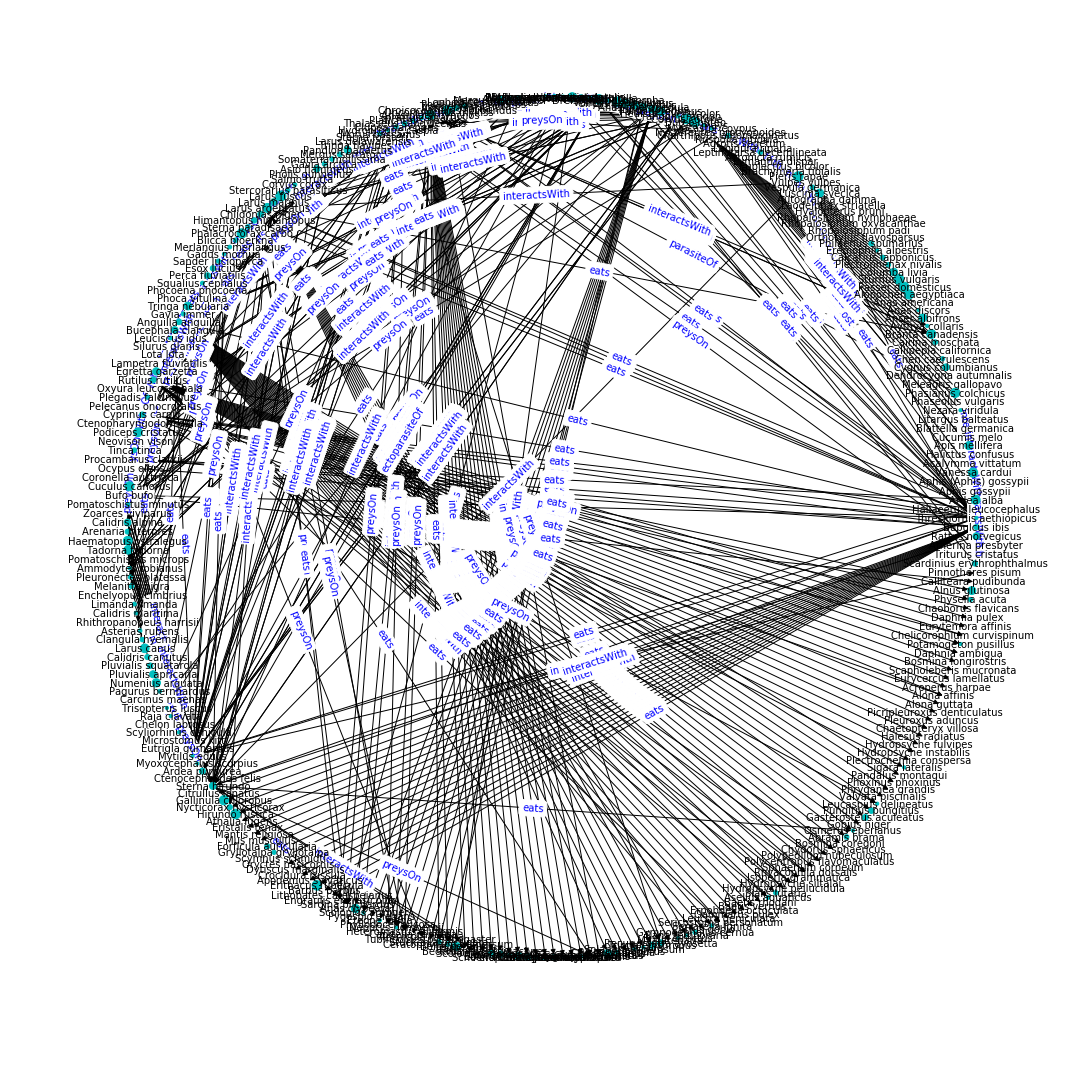

In [3111]:
plt.figure(figsize=(15,15))
edge_labels = nx.get_edge_attributes(G,'label')

#pos = nx.spring_layout(G, iterations=50, k=50) 
#pos = nx.spring_layout(G)
#pos = nx.random_layout(G)
pos = nx.circular_layout(G)
#pos = nx.spectral_layout(G)
#pos = nx.shell_layout(G, scale=1)

nodeColors = nx.get_node_attributes(G,'color')

nx.draw_networkx_edge_labels(G,pos, edge_labels = edge_labels, font_size=10, font_color='blue')

#nx.draw_networkx_nodes(G, pos, node_color=nodeColors.values())

nx.draw_networkx(G, pos, with_labels=True, node_size = listOfNodeSizes, node_color='c', alpha= 1, arrows=True, 
                    linewidths=1, font_color="black", font_size=10, style = 'dashed')

plt.axis('off')
plt.tight_layout()
plt.show()

In [3112]:
filename = "..\\docs\\"+taxon+country+".html"
with open(filename, "w") as file:
    file.write(" \
<!DOCTYPE html> \
<html> \
<head> \
<script src='cytoscape.min.js'></script> \
<script src='https://unpkg.com/layout-base/layout-base.js'></script> \
<script src='https://unpkg.com/cose-base/cose-base.js'></script> \
<script src='cytoscape-cose-bilkent.js'></script> \
</head> \
<style>#cy {width: 90%; height: 90%; position: absolute; top: 50px; left: 150px;}\
.red {color: red; font-style: bold;} \
.green {color: green; font-style: bold;} \
.blue {color: blue; font-style: bold;} \
.brown {color: brown; font-style: bold;} \
table, th, td {border: 1px solid black;} \
body {font-family: 'times; font-size: 6px;}\
</style> \
<body> \
<h1><em font-style: italic;>"+taxon+"</em> in "+country+"</h1>")

### Write out the details of the species

In [3113]:
with open(filename, "a") as file:
    if len(G.nodes)==0:
        file.write("<p>No interacting species have been found for "+taxon+" in "+country+".</p>") 
    else:
        file.write("<p>Nodes and edges can be moved and if clicked, open a tab with species or interaction details</p>") 
        file.write("<p>The target species is the <SPAN CLASS='red'>red node</SPAN>. <em>Plantae</em> are <SPAN CLASS='green'>green</SPAN>, <em>Animalia</em> are <SPAN CLASS='blue'>blue</SPAN> and everything else is <SPAN CLASS='brown'>brown</SPAN></p>") 
        file.write("<p>Node area is proportional to the 1 km<sup>2</sup> occupancy</p>")
    

In [3114]:
species = G.nodes
#with open(filename, "a") as file:
#    for n in species:
#        file.write("<tr><td><a target='_blank' href=https://www.gbif.org/species/"+str(nx.get_node_attributes(G, 'gbifkey')[n])+">"+n+"</a></td><td>"+str(dictOfNodeSizes[n])+"</td>\n")

In [3115]:
with open(filename, "a") as file: 
    if len(sourceInteractions) != 0:
        file.write("<p>Below is a table of all <a href='https://www.globalbioticinteractions.org/'>GloBI</a> interaction records that <em>"+taxon+"</em> has with other taxa</p>")
        file.write("<table><th>Interaction</th><th>number</th>")
        for n in sourceInteractions:
            file.write("<tr><td><a target='_blank' href=https://www.globalbioticinteractions.org/?interactionType="+str(n[0])+"&sourceTaxon="+taxon.replace(" ", "%20")+">"+str(n[0])+"</a></td><td>"+str(n[1])+"</td>\n")
        file.write("</table>") 
    if len(targetInteractions) != 0:
        file.write("<p>Below is a table of all <a href='https://www.globalbioticinteractions.org/'>GloBI</a> interaction records that other taxa have with <em>"+taxon+"</em></p>")
        file.write("<table><th>Interaction</th><th>number</th>")
        for n in targetInteractions:
            file.write("<tr><td><a target='_blank' href=https://www.globalbioticinteractions.org/?interactionType="+str(n[0])+"&targetTaxon="+taxon.replace(" ", "%20")+">"+str(n[0])+"</a></td><td>"+str(n[1])+"</td>\n") 
        file.write("</table>")
    

In [3116]:
file.close()

In [3117]:
with open(filename, "a") as file:
    file.write(" \
<div id='cy'></div> \
<script> \
var cy = cytoscape({ \
  container: document.getElementById('cy'), \n \
  elements: [ \
")

### Write nodes to file

In [3118]:
file = open(filename, "a")
for n in species:
    if n == taxon:
        file.write("{ data: { id: '"+n+"', href: 'https://www.gbif.org/species/"+str(nx.get_node_attributes(G, 'gbifkey')[n])+"', occnum: "+str(dictOfNodeSizes[n])+" }, selectable: true,},\n")
    else:
        file.write("{ data: { id: '"+n+"', kingdom: '"+kingdom[n]+"', href: 'https://www.gbif.org/species/"+str(nx.get_node_attributes(G, 'gbifkey')[n])+"', occnum: "+str(dictOfNodeSizes[n])+" }, selectable: false,},\n")
file.close()

### Write edges to file

In [3119]:
file = open(filename, "a")
for edge in G.edges:
    file.write("{data: {id: '"+edge[0]+edge[1]+"', source: '"+edge[0]+"', target: '"+edge[1]+"', href: 'https://www.globalbioticinteractions.org/?interactionType="+str(nx.get_edge_attributes(G, 'label')[edge])+"&sourceTaxon="+edge[0]+"&targetTaxon="+edge[1]+"', label: '"+nx.get_edge_attributes(G, 'label')[edge]+"'}},\n")
file.close()
    

In [3120]:
with open(filename, "a") as file:
    file.write("], \
style: [ \n\
        { \n\
            selector: 'node', \n\
            style: { \n\
                shape: 'circle', \n\
                'background-color': 'yellow', \n\
                label: 'data(id)', \n\
                'text-valign': 'center', \n\
                'font-family': 'helvetica', \n\
                'font-style': 'italic', \n\
                'font-size': '8px', \n\
                'border-width': '0.5', \n\
                'border-color': 'black', \n\
                'width': 'mapData(occnum, 0, 400, 3, 200)', \n\
                'height': 'mapData(occnum, 0, 400, 3, 200)' \n\
            } \n\
        },  \n\
        {  \n\
            selector: 'edge',  \n\
            style: {  \n\
                label: 'data(label)', \n\
                'font-family': 'helvetica', \n\
                'font-size': '6px', \n\
                'color': 'blue', \n\
                'curve-style': 'bezier', \n\
                'target-arrow-shape': 'triangle',  \n\
                'width': '1' \n\
                } \n\
         },  \n\
         {  \n\
              selector: '[kingdom = \"Plantae\"]',   \n\
              css: {  \n\
                'background-color': 'lightgreen'  \n\
                 }  \n\
        }, \n\
        {  \n\
              selector: '[kingdom = \"Animalia\"]',   \n\
              css: {  \n\
                'background-color': 'lightblue'  \n\
                 }  \n\
        }, \n\
        {  \n\
              selector: ':selected',   \n\
              css: {  \n\
                'line-color': 'red',  \n\
                'shape': 'square',  \n\
                'background-color': 'red'  \n\
                 }  \n\
        }], \n\
layout:  { \n\
            name: 'cose-bilkent', padding: 1, animate: true, gravity: 30, animationDuration: 3000 \n\
     } \n\
} \n\
); \n\
")

In [3121]:
with open(filename, "a") as file:
    file.write("cy.userZoomingEnabled( true ); \n\
    cy.getElementById('"+taxon+"').select(); \n\
    document.write('<br />Degree of node <em>"+fullScientificName+"</em> = '+cy.getElementById('"+taxon+"').degree()); \n\
    cy.on('tap', 'node', function(){ \n\
        try { // your browser may block popups \n\
              window.open( this.data('href') ); \n\
            } catch(e){ // fall back on url change \n\
        window.location.href = this.data('href'); \n\
    } \n\
}); \n\
    cy.on('tap', 'edge', function(){  \n\
        try { // your browser may block popups  \n\
              window.open( this.data('href') );  \n\
            } catch(e){ // fall back on url change  \n\
        window.location.href = this.data('href'); \n\
    } \n\
}); \n\
</script> \n\
")

In [3122]:
with open(filename, "a") as file:
    file.write("</ul> \
        <br /> \
        <br /> \
        <a href='https://github.com/AgentschapPlantentuinMeise/interactias'><img src='../images/Octocat.jpg' alt='GitHub logo' width='20'>Source code</a> \
        </body> \
        </html>")

In [3123]:
file.close()

In [3124]:
#with open(filename, "a") as file:
#    file.write("<h2>References</h2><ul>\n")

In [3125]:
citations = cleanInteractDataTaxon['sourceCitation'].unique()
#file = open(filename, "a")
for ref in citations:
    print("* ",str(ref))
#    file.write("<li>"+str(ref)+"</li>\n")
#file.close()

*  A. Thessen. 2014. Species associations extracted from EOL text data objects via text mining.
*  Ed Baker; Ian J. Kitching; George W. Beccaloni; Amoret Whitaker et al. (2016). Dataset: NHM Interactions Bank. Natural History Museum Data Portal (data.nhm.ac.uk). https://doi.org/10.5519/0060767
*  University of Michigan Museum of Zoology Insect Division. Full Database Export 2020-01-27 provided by Erika Tucker and Barry Oconner.
*  https://vertnet.org
*  Sarah E Miller. 7/6/2016. Arctos collection.
*  Sarah E Miller. 4/18/2016. Species associations from Wardeh, M. et al. Database of host-pathogen and related species interactions, and their global distribution. Sci. Data 2:150049 doi: 10.1038/sdata.2015.49 (2015)
*  Seltzer, Carrie; Wysocki, William; Palacios, Melissa; Eickhoff, Anna; Pilla, Hannah; Aungst, Jordan; Mercer, Aaron; Quicho, Jamie; Voss, Neil; Xu, Man; J. Ndangalasi, Henry; C. Lovett, Jon; J. Cordeiro, Norbert (2015): Plant-animal interactions from Africa. figshare. https://

### For import into Gephi: A nodes and edges file has been replace by the .dot file format

In [3126]:
write_dot(G, "..\\docs\\"+taxon+".dot")